# IEEE Card Fraud Detection

## Contents
1. Load Data
2. Exploratory Data Analysis
3. Building the base model
4. Building the tuned model

## 1. Load Data

In [1]:
import pandas as pd
import numpy as np

In [2]:
train_id = pd.read_csv("data/train_identity.csv")
train_txn = pd.read_csv("data/train_transaction.csv")

print(f"Shape of train identity: {train_id.shape}")
print(f"Shape of train transaction: {train_txn.shape}")

Shape of train identity: (144233, 41)
Shape of train transaction: (590540, 394)


In [3]:
test_id = pd.read_csv("data/test_identity.csv")
test_txn = pd.read_csv("data/test_transaction.csv")

In [61]:
# primary key is TransactionID
train_df = pd.merge(train_txn,train_id, how = 'left', on = 'TransactionID',validate = "many_to_one")
test_df = pd.merge(test_txn,test_id, how = 'left', on = 'TransactionID',validate = "many_to_one")

In [62]:
train_df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


## 2. Exploratory Data Analysis

In [63]:
import seaborn as sns
import math

In [64]:
fraud_rows = train_df[train_df['isFraud']==1].shape[0]
total_rows = train_df.shape[0]
print(f"{fraud_rows} out of {total_rows} observations were fradulent ({round(fraud_rows/total_rows, 2)}%)")

20663 out of 590540 observations were fradulent (0.03%)


#### Detect outliers

In [65]:
amts = train_df['TransactionAmt']

In [66]:
def zscore(lst):
    std_val = lst.std()
    avg_val = sum(lst) / len(lst)
    
    z_lst = [((x-avg_val) / std_val) for x in lst]
    
    return z_lst

In [67]:
train_df['TransactionAmtStd'] = zscore(train_df['TransactionAmt'])

In [68]:
def remove_outliers(df):
    df = df[df['TransactionAmtStd'] < 3]
    df = df[df['TransactionAmtStd'] > -3]
    
    return df

In [69]:
train_df.shape

(590540, 435)

In [70]:
train_df = remove_outliers(train_df)

In [71]:
train_df.shape

(580447, 435)

### Transaction Amount

Text(0.5, 1.0, 'Distribution of TransactionAmt')

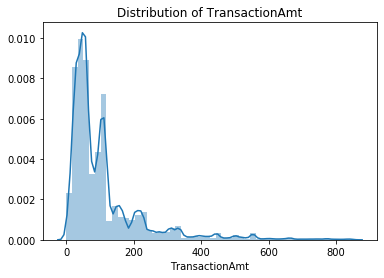

In [72]:
sns.distplot(train_df['TransactionAmt']).set_title('Distribution of TransactionAmt')

The data is skewed left, probably due to the majority of transactions being small (<100 in this case).

Text(0.5, 1.0, 'Log Distribution of TransactionAmt')

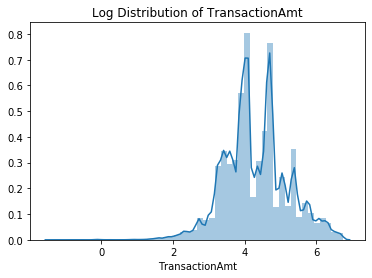

In [73]:
sns.distplot(np.log(train_df['TransactionAmt'])).set_title('Log Distribution of TransactionAmt')

### Transaction Date
Times are reported in seconds (relative)

In [74]:
# Difference between smallest and largest
earliest_day = train_df['TransactionDT'].min() / 86400
latest_day = train_df['TransactionDT'].max() / 86400
print(f"First day in Dataset: {earliest_day}")
print(f"Last day in Dataset: {latest_day}")

First day in Dataset: 1.0
Last day in Dataset: 182.99920138888888


### Product Attributes
Distirbution of the types of products being bought

In [75]:
product_codes = list(train_df['ProductCD'].unique())
print(f"There are {len(product_codes)} product codes: {product_codes}")

There are 5 product codes: ['W', 'H', 'C', 'S', 'R']


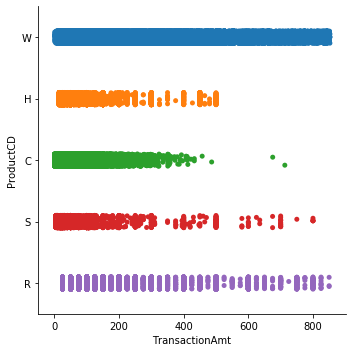

In [76]:
sns.catplot(x="TransactionAmt", y="ProductCD", data=train_df)

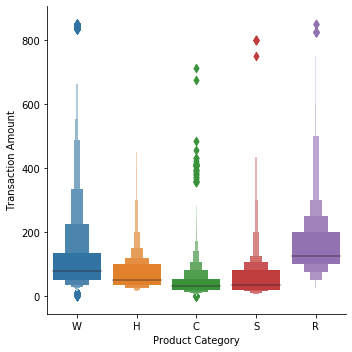

In [77]:
sns.catplot(x="ProductCD", y="TransactionAmt", kind="boxen", data=train_df)\
            .set(xlabel='Product Category', ylabel='Transaction Amount')

In [78]:
product_type_stdev = train_df.groupby('ProductCD').std()['TransactionAmt']
product_type_avg = train_df.groupby('ProductCD').mean()['TransactionAmt']
product_type = pd.DataFrame({"ProductCD": product_type_avg.index,
                             "Mean": list(product_type_avg), 
                             "Stdev": list(product_type_stdev)})

In [79]:
product_type

,ProductCD,Mean,Stdev
0,C,42.872353,38.943070
1,H,73.170058,61.950955
2,R,158.576564,108.257874
3,S,58.651787,69.656704
4,W,122.402702,126.121536


`W` Seems to have a high average due to it being more skewed, confirmed by the high standard deviation. 

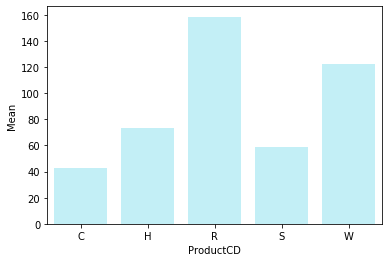

In [84]:
sns.barplot(x="ProductCD", y="Mean", data=product_type, color='#baf5ff')

In terms of average transactions, there are large differences between product categories. Different amounts could influence the likelihood of fradulent transactions occuring due to the nature of certain products.

### Card attributes

In [85]:
card_df = train_df[['card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'isFraud']]

#### `card4`: Are certain credit card providers more likely to have fraudulent transactions?

In [86]:
card_df.head()

,card1,card2,card3,card4,card5,card6,isFraud
0,13926,NaN,150.0,discover,142.0,credit,0
1,2755,404.0,150.0,mastercard,102.0,credit,0
2,4663,490.0,150.0,visa,166.0,debit,0
3,18132,567.0,150.0,mastercard,117.0,debit,0
4,4497,514.0,150.0,mastercard,102.0,credit,0


In [87]:
provider_count = card_df.groupby("card4").count()['isFraud']
provider_fraud_count = card_df.groupby("card4").sum()['isFraud']

In [88]:
provider_df = pd.merge(provider_count, provider_fraud_count, on='card4')
provider_df['pctFraud'] = provider_df['isFraud_y'] / provider_df['isFraud_x'] * 100
provider_df

,isFraud_x,isFraud_y,pctFraud
card4,,,
american express,8225,239,2.905775
discover,6171,436,7.065305
mastercard,186045,6396,3.437878
visa,378463,13013,3.438381


#### `card6`: is credit or debit more likely to be fraudulent?

In [89]:
cred_deb = train_df[['card6', 'TransactionAmt', 'isFraud']]

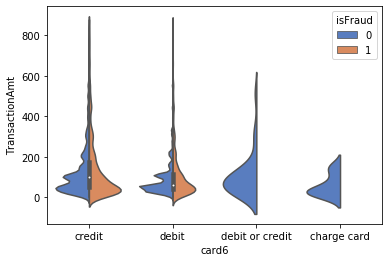

In [91]:
ax = sns.violinplot(x="card6", y="TransactionAmt", hue="isFraud", data=cred_deb, palette="muted", split=True)

Seems like on a proportion basis, credit cards are more likely to have fraudulent transactions.

In [92]:
debit_fraud = cred_deb[cred_deb['isFraud']==1]['card6'].value_counts()['debit']
credit_fraud = cred_deb[cred_deb['isFraud']==1]['card6'].value_counts()['credit']

debit_total = cred_deb['card6'].value_counts()['debit']
credit_total = cred_deb['card6'].value_counts()['credit']

print(f"There are {debit_fraud} debit fraudulent transactions ({round(debit_fraud/debit_total, 3)})%")
print(f"There are {credit_fraud} credit fraudulent transactions ({round(credit_fraud/credit_total, 3)})%")

There are 10493 debit fraudulent transactions (0.024)%
There are 9593 credit fraudulent transactions (0.067)%


Looks like credit cards are 3 times more likely to have a fraudulent transaction compared to debit cards

### Device Type

#### `DeviceType` is composed of mobile, desktop or NAN

In [96]:
train_df['DeviceType'].unique()

array([nan, 'mobile', 'desktop'], dtype=object)